In [1]:
from pyspark.sql import SparkSession
from os.path import abspath

warehouse_location = abspath('spark-warehouse')

spark = SparkSession.builder    \
    .config('spark.driver.memory', '32g')   \
    .config("spark.sql.warehouse.dir", warehouse_location) \
    .config("spark.sql.catalogImplementation","hive") \
    .enableHiveSupport()   \
    .getOrCreate()
spark

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/06/12 23:42:16 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
orders_sdf = spark.read.csv('data/instacart_market/orders.csv', header=True, inferSchema=True)
order_products_train_sdf = spark.read.csv('data/instacart_market/order_products_train.csv', header=True, inferSchema=True)
order_products_prior_sdf = spark.read.csv('data/instacart_market/order_products_prior.csv', header=True, inferSchema=True)
products_sdf = spark.read.csv('data/instacart_market/products.csv', header=True, inferSchema=True)
aisles_sdf = spark.read.csv('data/instacart_market/aisles.csv', header=True, inferSchema=True)
departments_sdf = spark.read.csv('data/instacart_market/departments.csv', header=True, inferSchema=True)

In [3]:
sdf_dict = {
    'orders': orders_sdf,
    'order_products_train': order_products_train_sdf,
    'order_products_prior': order_products_prior_sdf,
    'products': products_sdf,
    'aisles': aisles_sdf,
    'departments': departments_sdf,
}
for sdf_name, sdf in sdf_dict.items():
    print(f'{sdf_name} schema')
    print(sdf.printSchema())

orders schema
root
 |-- order_id: integer (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- eval_set: string (nullable = true)
 |-- order_number: integer (nullable = true)
 |-- order_dow: integer (nullable = true)
 |-- order_hour_of_day: integer (nullable = true)
 |-- days_since_prior_order: double (nullable = true)

None
order_products_train schema
root
 |-- order_id: integer (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- add_to_cart_order: integer (nullable = true)
 |-- reordered: integer (nullable = true)

None
order_products_prior schema
root
 |-- order_id: integer (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- add_to_cart_order: integer (nullable = true)
 |-- reordered: integer (nullable = true)

None
products schema
root
 |-- product_id: integer (nullable = true)
 |-- product_name: string (nullable = true)
 |-- aisle_id: string (nullable = true)
 |-- department_id: string (nullable = true)

None
aisles schema
root
 |-- aisle_id: 

In [4]:
for name, sdf in sdf_dict.items():
    sdf.createOrReplaceTempView(name)

In [5]:
spark.catalog.listTables()

23/06/12 23:42:30 WARN HiveConf: HiveConf of name hive.stats.jdbc.timeout does not exist
23/06/12 23:42:30 WARN HiveConf: HiveConf of name hive.stats.retries.wait does not exist
23/06/12 23:42:35 WARN ObjectStore: Version information not found in metastore. hive.metastore.schema.verification is not enabled so recording the schema version 2.3.0
23/06/12 23:42:35 WARN ObjectStore: setMetaStoreSchemaVersion called but recording version is disabled: version = 2.3.0, comment = Set by MetaStore UNKNOWN@172.17.0.2
23/06/12 23:42:36 WARN ObjectStore: Failed to get database global_temp, returning NoSuchObjectException


[Table(name='priors_trains', catalog='spark_catalog', namespace=['default'], description=None, tableType='MANAGED', isTemporary=False),
 Table(name='aisles', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='departments', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='order_products_prior', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='order_products_train', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='orders', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='products', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True)]

In [6]:
spark.sql('select * from orders limit 100').show(100)

+--------+-------+--------+------------+---------+-----------------+----------------------+
|order_id|user_id|eval_set|order_number|order_dow|order_hour_of_day|days_since_prior_order|
+--------+-------+--------+------------+---------+-----------------+----------------------+
| 2539329|      1|   prior|           1|        2|                8|                  null|
| 2398795|      1|   prior|           2|        3|                7|                  15.0|
|  473747|      1|   prior|           3|        3|               12|                  21.0|
| 2254736|      1|   prior|           4|        4|                7|                  29.0|
|  431534|      1|   prior|           5|        4|               15|                  28.0|
| 3367565|      1|   prior|           6|        2|                7|                  19.0|
|  550135|      1|   prior|           7|        1|                9|                  20.0|
| 3108588|      1|   prior|           8|        1|               14|            

In [7]:
spark.sql('select * from orders where user_id = 1').show()

+--------+-------+--------+------------+---------+-----------------+----------------------+
|order_id|user_id|eval_set|order_number|order_dow|order_hour_of_day|days_since_prior_order|
+--------+-------+--------+------------+---------+-----------------+----------------------+
| 2539329|      1|   prior|           1|        2|                8|                  null|
| 2398795|      1|   prior|           2|        3|                7|                  15.0|
|  473747|      1|   prior|           3|        3|               12|                  21.0|
| 2254736|      1|   prior|           4|        4|                7|                  29.0|
|  431534|      1|   prior|           5|        4|               15|                  28.0|
| 3367565|      1|   prior|           6|        2|                7|                  19.0|
|  550135|      1|   prior|           7|        1|                9|                  20.0|
| 3108588|      1|   prior|           8|        1|               14|            

In [8]:
spark.sql('select * from order_products_prior limit 10').show()

+--------+----------+-----------------+---------+
|order_id|product_id|add_to_cart_order|reordered|
+--------+----------+-----------------+---------+
|       2|     33120|                1|        1|
|       2|     28985|                2|        1|
|       2|      9327|                3|        0|
|       2|     45918|                4|        1|
|       2|     30035|                5|        0|
|       2|     17794|                6|        1|
|       2|     40141|                7|        1|
|       2|      1819|                8|        1|
|       2|     43668|                9|        0|
|       3|     33754|                1|        1|
+--------+----------+-----------------+---------+



In [9]:
spark.sql('select * from order_products_prior where order_id = 2398795').show()

+--------+----------+-----------------+---------+
|order_id|product_id|add_to_cart_order|reordered|
+--------+----------+-----------------+---------+
| 2398795|       196|                1|        1|
| 2398795|     10258|                2|        0|
| 2398795|     12427|                3|        1|
| 2398795|     13176|                4|        0|
| 2398795|     26088|                5|        1|
| 2398795|     13032|                6|        0|
+--------+----------+-----------------+---------+



In [10]:
spark.sql('select * from order_products_prior where order_id = 2539329').show()

+--------+----------+-----------------+---------+
|order_id|product_id|add_to_cart_order|reordered|
+--------+----------+-----------------+---------+
| 2539329|       196|                1|        0|
| 2539329|     14084|                2|        0|
| 2539329|     12427|                3|        0|
| 2539329|     26088|                4|        0|
| 2539329|     26405|                5|        0|
+--------+----------+-----------------+---------+



In [11]:
spark.sql('select * from order_products_train').show()

+--------+----------+-----------------+---------+
|order_id|product_id|add_to_cart_order|reordered|
+--------+----------+-----------------+---------+
|       1|     49302|                1|        1|
|       1|     11109|                2|        1|
|       1|     10246|                3|        0|
|       1|     49683|                4|        0|
|       1|     43633|                5|        1|
|       1|     13176|                6|        0|
|       1|     47209|                7|        0|
|       1|     22035|                8|        1|
|      36|     39612|                1|        0|
|      36|     19660|                2|        1|
|      36|     49235|                3|        0|
|      36|     43086|                4|        1|
|      36|     46620|                5|        1|
|      36|     34497|                6|        1|
|      36|     48679|                7|        1|
|      36|     46979|                8|        1|
|      38|     11913|                1|        0|


In [12]:
spark.sql('select * from order_products_train where order_id = 1').show()

+--------+----------+-----------------+---------+
|order_id|product_id|add_to_cart_order|reordered|
+--------+----------+-----------------+---------+
|       1|     49302|                1|        1|
|       1|     11109|                2|        1|
|       1|     10246|                3|        0|
|       1|     49683|                4|        0|
|       1|     43633|                5|        1|
|       1|     13176|                6|        0|
|       1|     47209|                7|        0|
|       1|     22035|                8|        1|
+--------+----------+-----------------+---------+



In [13]:
spark.sql('select * from orders where user_id = (select user_id from orders where order_id = 1)').show()

+--------+-------+--------+------------+---------+-----------------+----------------------+
|order_id|user_id|eval_set|order_number|order_dow|order_hour_of_day|days_since_prior_order|
+--------+-------+--------+------------+---------+-----------------+----------------------+
| 1427983| 112108|   prior|           1|        1|               14|                  null|
| 2541372| 112108|   prior|           2|        1|               10|                   7.0|
|  186706| 112108|   prior|           3|        2|               21|                  15.0|
|       1| 112108|   train|           4|        4|               10|                   9.0|
+--------+-------+--------+------------+---------+-----------------+----------------------+



In [14]:
spark.sql('''
select * from products
''').show(truncate=False)

+----------+-----------------------------------------------------------------+--------+-------------+
|product_id|product_name                                                     |aisle_id|department_id|
+----------+-----------------------------------------------------------------+--------+-------------+
|1         |Chocolate Sandwich Cookies                                       |61      |19           |
|2         |All-Seasons Salt                                                 |104     |13           |
|3         |Robust Golden Unsweetened Oolong Tea                             |94      |7            |
|4         |Smart Ones Classic Favorites Mini Rigatoni With Vodka Cream Sauce|38      |1            |
|5         |Green Chile Anytime Sauce                                        |5       |13           |
|6         |Dry Nose Oil                                                     |11      |11           |
|7         |Pure Coconut Water With Orange                                   |98  

In [15]:
spark.sql('''
select * from aisles
''').show(truncate=False)

+--------+----------------------------+
|aisle_id|aisle                       |
+--------+----------------------------+
|1       |prepared soups salads       |
|2       |specialty cheeses           |
|3       |energy granola bars         |
|4       |instant foods               |
|5       |marinades meat preparation  |
|6       |other                       |
|7       |packaged meat               |
|8       |bakery desserts             |
|9       |pasta sauce                 |
|10      |kitchen supplies            |
|11      |cold flu allergy            |
|12      |fresh pasta                 |
|13      |prepared meals              |
|14      |tofu meat alternatives      |
|15      |packaged seafood            |
|16      |fresh herbs                 |
|17      |baking ingredients          |
|18      |bulk dried fruits vegetables|
|19      |oils vinegars               |
|20      |oral hygiene                |
+--------+----------------------------+
only showing top 20 rows



In [16]:
spark.sql('''
select * from departments
''').show(truncate=False)

+-------------+---------------+
|department_id|department     |
+-------------+---------------+
|1            |frozen         |
|2            |other          |
|3            |bakery         |
|4            |produce        |
|5            |alcohol        |
|6            |international  |
|7            |beverages      |
|8            |pets           |
|9            |dry goods pasta|
|10           |bulk           |
|11           |personal care  |
|12           |meat seafood   |
|13           |pantry         |
|14           |breakfast      |
|15           |canned goods   |
|16           |dairy eggs     |
|17           |household      |
|18           |babies         |
|19           |snacks         |
|20           |deli           |
+-------------+---------------+
only showing top 20 rows



In [17]:
spark.sql('''
select p.*, a.aisle, d.department
from products p, aisles a, departments d
where p.aisle_id = a.aisle_id and p.department_id = d.department_id
''').show(truncate=False)

+----------+-----------------------------------------------------------------+--------+-------------+-----------------------------+---------------+
|product_id|product_name                                                     |aisle_id|department_id|aisle                        |department     |
+----------+-----------------------------------------------------------------+--------+-------------+-----------------------------+---------------+
|1         |Chocolate Sandwich Cookies                                       |61      |19           |cookies cakes                |snacks         |
|2         |All-Seasons Salt                                                 |104     |13           |spices seasonings            |pantry         |
|3         |Robust Golden Unsweetened Oolong Tea                             |94      |7            |tea                          |beverages      |
|4         |Smart Ones Classic Favorites Mini Rigatoni With Vodka Cream Sauce|38      |1            |frozen meal

In [18]:
spark.sql('''
select 'priors_cnt' as table_name_count, count(*) cnt from order_products_prior
union all
select 'trains_cnt', count(*) cnt from order_products_train     
union all
select 'orders_cnt', count(*) cnt from orders
''').show()

+----------------+--------+
|table_name_count|     cnt|
+----------------+--------+
|      priors_cnt|32434489|
|      trains_cnt| 1384617|
|      orders_cnt| 3421083|
+----------------+--------+



In [19]:
spark.sql('''
select eval_set, count(*)
from orders
group by eval_set
''').show(truncate=False)

+--------+--------+
|eval_set|count(1)|
+--------+--------+
|train   |131209  |
|prior   |3214874 |
|test    |75000   |
+--------+--------+



In [20]:
spark.sql('''
select eval_set, count(distinct user_id)
from orders
group by eval_set
''').show(truncate=False)

+--------+-----------------------+
|eval_set|count(DISTINCT user_id)|
+--------+-----------------------+
|train   |131209                 |
|prior   |206209                 |
|test    |75000                  |
+--------+-----------------------+



In [21]:
spark.sql('''
select user_id, count(*)
from orders
group by user_id
''').show(truncate=False)

+-------+--------+
|user_id|count(1)|
+-------+--------+
|148    |8       |
|463    |8       |
|471    |7       |
|496    |83      |
|833    |12      |
|1088   |16      |
|1238   |30      |
|1342   |7       |
|1580   |10      |
|1591   |4       |
|1645   |9       |
|1829   |7       |
|1959   |5       |
|2122   |11      |
|2142   |14      |
|2366   |31      |
|2659   |18      |
|2866   |38      |
|3175   |10      |
|3749   |27      |
+-------+--------+
only showing top 20 rows



In [22]:
spark.sql('''
select user_id, count(*)
from orders
group by user_id 
order by 2 desc
''').show(truncate=False)

+-------+--------+
|user_id|count(1)|
+-------+--------+
|1683   |100     |
|5912   |100     |
|10502  |100     |
|6398   |100     |
|5932   |100     |
|6448   |100     |
|6268   |100     |
|5329   |100     |
|210    |100     |
|9320   |100     |
|4807   |100     |
|1310   |100     |
|8086   |100     |
|7279   |100     |
|2405   |100     |
|7278   |100     |
|7120   |100     |
|5449   |100     |
|6978   |100     |
|4382   |100     |
+-------+--------+
only showing top 20 rows



In [23]:
spark.sql('''
select max(cnt), min(cnt), avg(cnt), count(*)
from
(
select user_id, count(*) cnt
from orders
group by user_id 
)
order by 2 desc
''').show(truncate=False)

+--------+--------+------------------+--------+
|max(cnt)|min(cnt)|avg(cnt)          |count(1)|
+--------+--------+------------------+--------+
|100     |4       |16.590367054784224|206209  |
+--------+--------+------------------+--------+



In [24]:
spark.sql('''
with
user_cnt_group as
(
select user_id, count(*) as user_cnt from orders group by user_id 
)
select user_cnt_bin || '-' || (user_cnt_bin + 10) as user_cnt_bin_range, bin_count
from (
select floor(user_cnt / 10.0) * 10 as user_cnt_bin, count(*) bin_count
from user_cnt_group
group by floor(user_cnt / 10.0) * 10
)
order by bin_count desc
''').show(truncate=False)

+------------------+---------+
|user_cnt_bin_range|bin_count|
+------------------+---------+
|0-10              |95481    |
|10-20             |56797    |
|20-30             |23254    |
|30-40             |11897    |
|40-50             |7316     |
|50-60             |4572     |
|60-70             |2479     |
|70-80             |1468     |
|100-110           |1374     |
|80-90             |955      |
|90-100            |616      |
+------------------+---------+



In [25]:
spark.sql('''
select class, max(cnt), min(cnt), avg(cnt)
from (
select 'prior' as class, product_id, count(*) as cnt from order_products_prior group by product_id
union all
select 'train' as class, product_id, count(*) as cnt from order_products_train group by product_id
) group by class
''').show(truncate=False)

+-----+--------+--------+-----------------+
|class|max(cnt)|min(cnt)|avg(cnt)         |
+-----+--------+--------+-----------------+
|prior|472565  |1       |652.90756285605  |
|train|18726   |1       |35.39138102906219|
+-----+--------+--------+-----------------+



In [26]:
spark.sql('''
drop table if exists priors_trains
''').show(truncate=False)

++
||
++
++



In [27]:
spark.sql('''
create table priors_trains
as
select 'train' as class, t.* from order_products_train t
union all
select 'prior' as class, p.* from order_products_prior p 
''').show(truncate=False)

23/06/12 23:43:05 WARN ResolveSessionCatalog: A Hive serde table will be created as there is no table provider specified. You can set spark.sql.legacy.createHiveTableByDefault to false so that native data source table will be created instead.
23/06/12 23:43:05 WARN SessionState: METASTORE_FILTER_HOOK will be ignored, since hive.security.authorization.manager is set to instance of HiveAuthorizerFactory.
23/06/12 23:43:05 WARN HiveConf: HiveConf of name hive.internal.ss.authz.settings.applied.marker does not exist
23/06/12 23:43:05 WARN HiveConf: HiveConf of name hive.stats.jdbc.timeout does not exist
23/06/12 23:43:05 WARN HiveConf: HiveConf of name hive.stats.retries.wait does not exist
23/06/12 23:43:05 WARN HiveMetaStore: Location: file:/workspace/apache-spark-ml/spark-warehouse/priors_trains specified for non-external table:priors_trains


++
||
++
++



In [28]:
spark.catalog.listTables()

[Table(name='priors_trains', catalog='spark_catalog', namespace=['default'], description=None, tableType='MANAGED', isTemporary=False),
 Table(name='aisles', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='departments', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='order_products_prior', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='order_products_train', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='orders', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True),
 Table(name='products', catalog=None, namespace=[], description=None, tableType='TEMPORARY', isTemporary=True)]

In [29]:
spark.sql('''
cache table priors_trains
''').show()
# spark.sql('''
# uncache table priors_trains
# ''').show()

++
||
++
++



In [61]:
spark.sql('''
select product_id, count(*)
from priors_trains
group by product_id
order by 2 desc
''').show(truncate=False)

+----------+--------+
|product_id|count(1)|
+----------+--------+
|24852     |491291  |
|13176     |394930  |
|21137     |275577  |
|21903     |251705  |
|47209     |220877  |
|47766     |184224  |
|47626     |160792  |
|16797     |149445  |
|26209     |146660  |
|27845     |142813  |
|27966     |142603  |
|22935     |117716  |
|24964     |113936  |
|45007     |109412  |
|39275     |105026  |
|49683     |99728   |
|28204     |92889   |
|5876      |91251   |
|40706     |88078   |
|8277      |87272   |
+----------+--------+
only showing top 20 rows



In [35]:
spark.sql('''
select *
from priors_trains
''').show(truncate=False)

+-----+--------+----------+-----------------+---------+
|class|order_id|product_id|add_to_cart_order|reordered|
+-----+--------+----------+-----------------+---------+
|train|2915697 |1141      |19               |1        |
|train|2915697 |4041      |20               |0        |
|train|2915697 |43209     |21               |1        |
|train|2915786 |24852     |1                |1        |
|train|2915786 |37524     |2                |0        |
|train|2915786 |29487     |3                |0        |
|train|2915786 |43789     |4                |1        |
|train|2915786 |21174     |5                |0        |
|train|2915786 |21137     |6                |1        |
|train|2915786 |5450      |7                |1        |
|train|2915786 |37859     |8                |1        |
|train|2915786 |39787     |9                |1        |
|train|2915798 |8718      |1                |1        |
|train|2915798 |25623     |2                |1        |
|train|2915798 |38881     |3                |1  

+-----+----------+------+--------------------+--------------------+----------+
|class|product_id|   cnt|        product_name|               aisle|department|
+-----+----------+------+--------------------+--------------------+----------+
|prior|     24852|472565|              Banana|        fresh fruits|   produce|
|prior|     13176|379450|Bag of Organic Ba...|        fresh fruits|   produce|
|prior|     21137|264683|Organic Strawberries|        fresh fruits|   produce|
|prior|     21903|241921|Organic Baby Spinach|packaged vegetabl...|   produce|
|prior|     47209|213584|Organic Hass Avocado|        fresh fruits|   produce|
|prior|     47766|176815|     Organic Avocado|        fresh fruits|   produce|
|prior|     47626|152657|         Large Lemon|        fresh fruits|   produce|
|prior|     16797|142951|        Strawberries|        fresh fruits|   produce|
|prior|     26209|140627|               Limes|        fresh fruits|   produce|
|prior|     27845|137905|  Organic Whole Milk|      

<Axes: xlabel='product_name'>

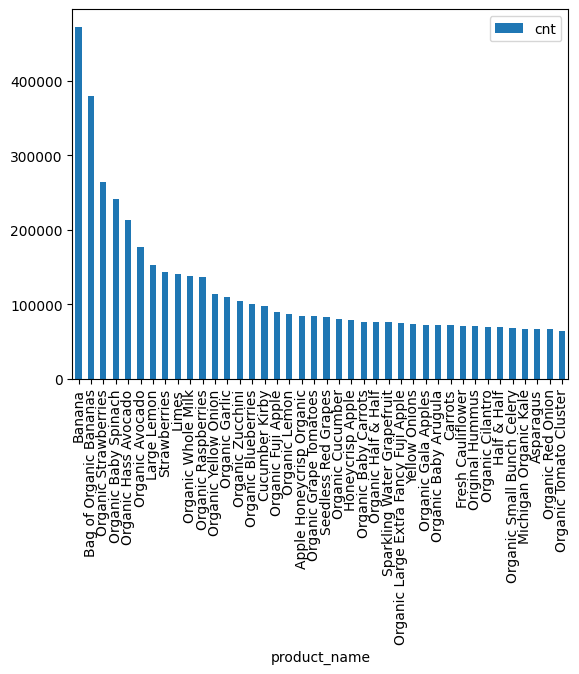

In [68]:
group_result_sdf = spark.sql("""
with order_prods_group as
(
select class, product_id, count(*) cnt 
from priors_trains
group by class, product_id
)
select o.*, p.product_name, a.aisle, d.department
from order_prods_group o, products p, aisles a, departments d 
where o.product_id = p.product_id 
and p.aisle_id = a.aisle_id
and p.department_id = d.department_id
order by o.cnt desc limit 1000
""")
group_result_sdf.show()
group_result_pdf = group_result_sdf.toPandas()
group_result_pdf[:40].plot.bar(x='product_name', y='cnt')

In [36]:
spark.sql('''
with
order_prods_group as
(
select class, product_id, count(*) as cnt
from priors_trains
group by class, product_id
)
select o.*, p.product_name
from order_prods_group o, products p
where o.product_id = p.product_id
order by o.cnt desc limit 1000
''').show(1000, truncate=False)

+-----+----------+------+---------------------------------------------------------------------------------------------+
|class|product_id|cnt   |product_name                                                                                 |
+-----+----------+------+---------------------------------------------------------------------------------------------+
|prior|24852     |472565|Banana                                                                                       |
|prior|13176     |379450|Bag of Organic Bananas                                                                       |
|prior|21137     |264683|Organic Strawberries                                                                         |
|prior|21903     |241921|Organic Baby Spinach                                                                         |
|prior|47209     |213584|Organic Hass Avocado                                                                         |
|prior|47766     |176815|Organic Avocado

In [69]:
group_result_sdf = spark.sql('''
with
order_department_group as
(
select pt.class, p.department_id, count(*) as cnt
from priors_trains pt, products p
where pt.product_id = p.product_id
group by class, p.department_id
)
select o.*, d.department
from order_department_group o, departments d
where o.department_id = d.department_id
order by cnt desc limit 10
''')
group_result_pdf = group_result_sdf.toPandas()
group_result_pdf

,class,department_id,cnt,department
0,prior,4,9479291,produce
1,prior,16,5414016,dairy eggs
2,prior,19,2887550,snacks
3,prior,7,2690129,beverages
4,prior,1,2236432,frozen
5,prior,13,1875577,pantry
6,prior,3,1176787,bakery
7,prior,15,1068058,canned goods
8,prior,20,1051249,deli
9,prior,9,866627,dry goods pasta


In [70]:
group_result_sdf = spark.sql('''
with order_prods_group as
(
select class, product_id, count(*) cnt 
from priors_trains
group by class, product_id
)
select o.*, p.product_name, a.aisle, d.department
from order_prods_group o, products p, aisles a, departments d 
where o.product_id = p.product_id 
and p.aisle_id = a.aisle_id
and p.department_id = d.department_id
order by o.cnt desc limit 1000
''')
group_result_pdf = group_result_sdf.toPandas()
group_result_pdf

,class,product_id,cnt,product_name,aisle,department
0,prior,24852,472565,Banana,fresh fruits,produce
1,prior,13176,379450,Bag of Organic Bananas,fresh fruits,produce
2,prior,21137,264683,Organic Strawberries,fresh fruits,produce
3,prior,21903,241921,Organic Baby Spinach,packaged vegetables fruits,produce
4,prior,47209,213584,Organic Hass Avocado,fresh fruits,produce
...,...,...,...,...,...,...
995,prior,2361,5502,Mint Chip,ice cream ice,frozen
996,prior,22556,5497,All Natural Apricot Sparkling Water,water seltzer sparkling water,beverages
997,prior,18670,5497,Original Enriched Rice Drink,soy lactosefree,dairy eggs
998,prior,12797,5488,Organic Whole Peeled Tomatoes,canned jarred vegetables,canned goods


<Axes: xlabel='product_name'>

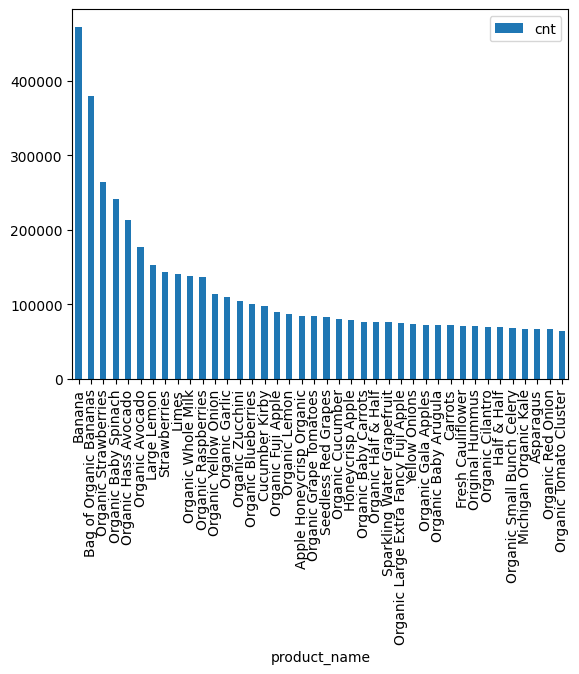

In [75]:
group_result_pdf.iloc[:40, :].plot.bar(x='product_name', y='cnt', rot=90)

<Axes: xlabel='aisle'>

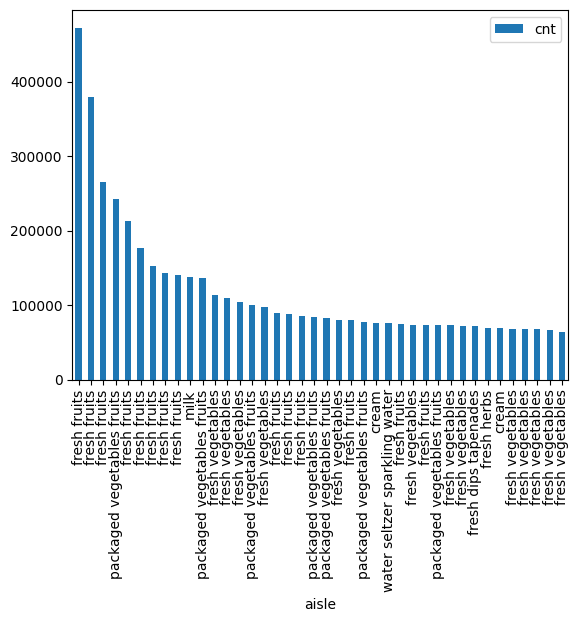

In [76]:
group_result_pdf.iloc[:40, :].plot.bar(x='aisle', y='cnt', rot=90)

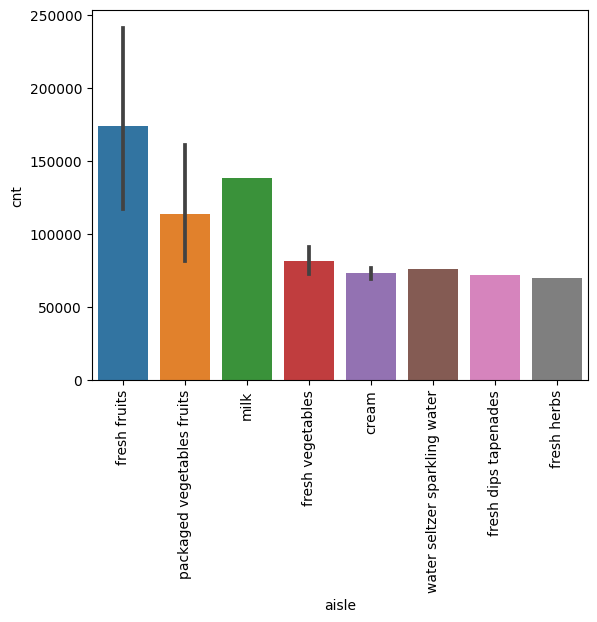

In [72]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(x='aisle', y='cnt', data=group_result_pdf[:40])
plt.xticks(rotation=90)
plt.show()

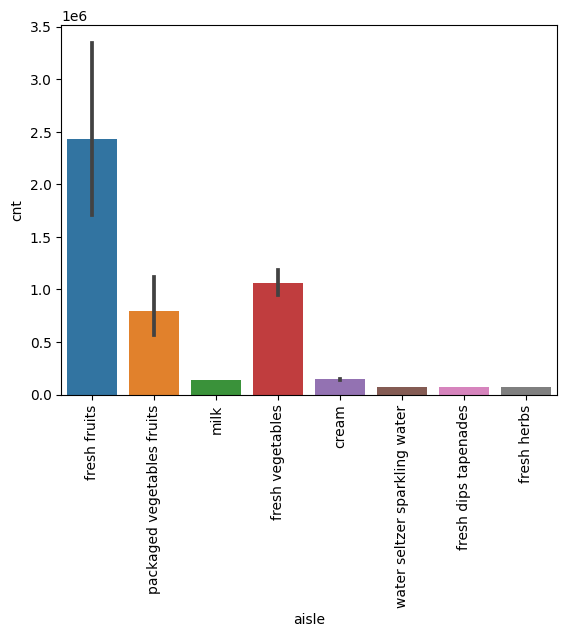

In [77]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(x='aisle', y='cnt', data=group_result_pdf[:40], estimator='sum')
plt.xticks(rotation=90)
plt.show()

In [73]:
group_result_sdf = spark.sql("""
select class, count(*) cnt
from priors_trains
group by class
""").show()

+-----+--------+
|class|     cnt|
+-----+--------+
|train| 1384617|
|prior|32434489|
+-----+--------+



+-----+----------+---------+------+--------------------+--------------------+----------+
|class|product_id|reordered|   cnt|        product_name|               aisle|department|
+-----+----------+---------+------+--------------------+--------------------+----------+
|prior|     24852|        1|398609|              Banana|        fresh fruits|   produce|
|prior|     13176|        1|315913|Bag of Organic Ba...|        fresh fruits|   produce|
|prior|     21137|        1|205845|Organic Strawberries|        fresh fruits|   produce|
|prior|     21903|        1|186884|Organic Baby Spinach|packaged vegetabl...|   produce|
|prior|     47209|        1|170131|Organic Hass Avocado|        fresh fruits|   produce|
|prior|     47766|        1|134044|     Organic Avocado|        fresh fruits|   produce|
|prior|     27845|        1|114510|  Organic Whole Milk|                milk|dairy eggs|
|prior|     47626|        1|106255|         Large Lemon|        fresh fruits|   produce|
|prior|     27966|   

<Axes: xlabel='product_name'>

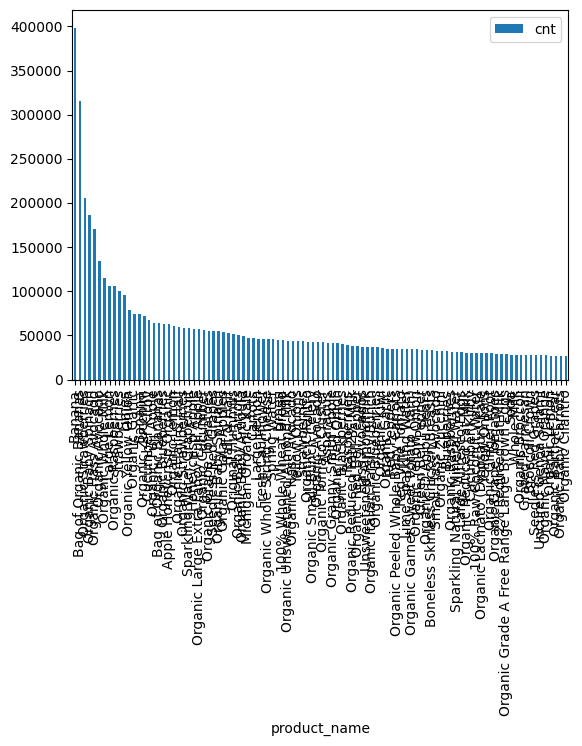

In [109]:
query = '''
with 
order_products_group as
(
select class, product_id, reordered, count(*) cnt
from priors_trains
group by class, product_id, reordered
)
select o.*, p.product_name, a.aisle, d.department
from order_products_group o, products p, aisles a, departments d
where o.product_id = p.product_id
and p.aisle_id = a.aisle_id
and p.department_id = d.department_id
order by o.cnt desc limit 100
'''
order_products_group_sdf = spark.sql(query)
order_products_group_sdf.show()
order_products_group_pdf = order_products_group_sdf.toPandas()
order_products_group_pdf.plot.bar(x='product_name', y='cnt')

+----------+-------------+-----------------+-----------------+------------------+--------------------+--------------------+--------------------+-------------+
|product_id|reordered_cnt|not_reordered_cnt|product_total_cnt|     reordered_pct|   not_reordered_pct|        product_name|               aisle|   department|
+----------+-------------+-----------------+-----------------+------------------+--------------------+--------------------+--------------------+-------------+
|      6433|           65|                4|               69|0.9420289855072463|0.057971014492753624| Raw Veggie Wrappers|      prepared meals|         deli|
|      2075|           84|                6|               90|0.9333333333333333| 0.06666666666666667|Serenity Ultimate...|       feminine care|personal care|
|     43553|           12|                1|               13|0.9230769230769231| 0.07692307692307693| Orange Energy Shots|energy sports drinks|    beverages|
|     27740|           94|                8|  

<Axes: xlabel='product_name'>

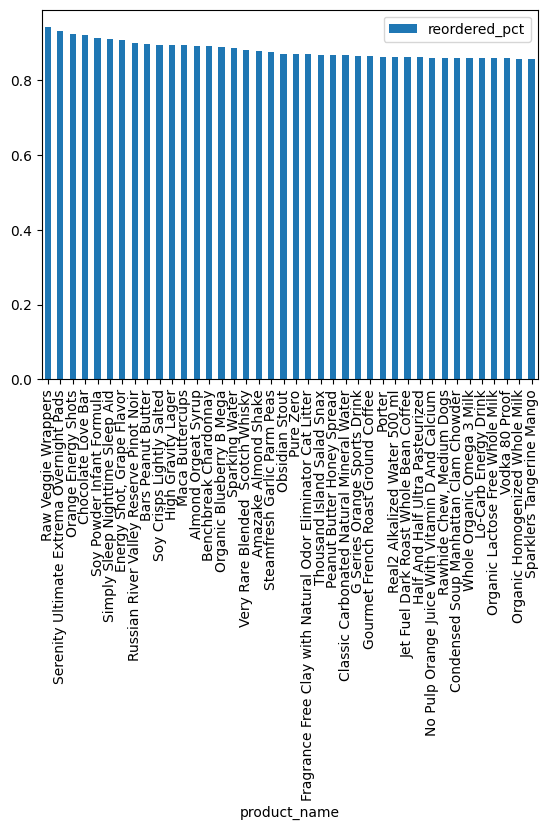

In [118]:
query = '''
with 
order_products_group as
(
select product_id,
sum(case when reordered = 1 then 1 else 0 end) as reordered_cnt,
sum(case when reordered = 0 then 1 else 0 end) as not_reordered_cnt,
count(*) product_total_cnt
from priors_trains
group by product_id
)
select o.*,
reordered_cnt / product_total_cnt as reordered_pct,
not_reordered_cnt / product_total_cnt as not_reordered_pct,
p.product_name, a.aisle, d.department
from order_products_group o, products p, aisles a, departments d
where o.product_id = p.product_id
and p.aisle_id = a.aisle_id
and p.department_id = d.department_id
order by reordered_pct desc limit 1000
'''
group_result_sdf = spark.sql(query)
group_result_sdf.show()
group_result_pdf = group_result_sdf.toPandas()
group_result_pdf[:40].plot.bar(x='product_name', y='reordered_pct')

<Axes: xlabel='reordered_pct', ylabel='reordered_cnt'>

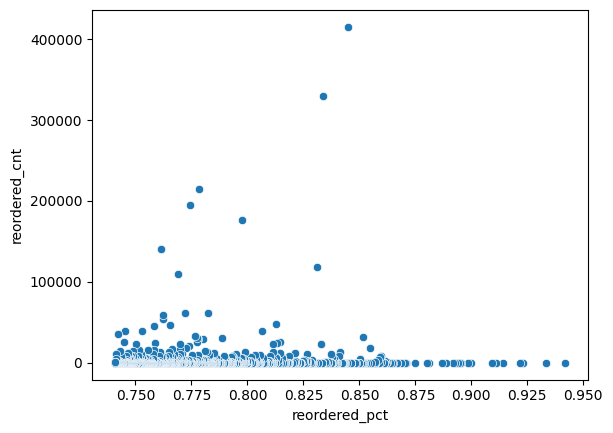

In [89]:
sns.scatterplot(data=group_result_pdf, x='reordered_pct', y='reordered_cnt')

In [115]:
query = '''
with 
order_products_group as
(
select product_id,
sum(case when reordered = 1 then 1 else 0 end) as reordered_cnt,
sum(case when reordered = 0 then 1 else 0 end) as not_reordered_cnt,
count(*) product_total_cnt
from priors_trains
group by product_id
)
select o.*,
reordered_cnt / product_total_cnt as reordered_pct,
not_reordered_cnt / product_total_cnt as not_reordered_pct,
p.product_name, a.aisle, d.department
from order_products_group o, products p, aisles a, departments d
where o.product_id = p.product_id
and p.aisle_id = a.aisle_id
and p.department_id = d.department_id
and reordered_cnt > 100000 and reordered_cnt / product_total_cnt > 0.7
order by reordered_pct desc limit 1000
'''
group_result_sdf = spark.sql(query)
group_result_sdf.show()
group_result_pdf = group_result_sdf.toPandas()

+----------+-------------+-----------------+-----------------+------------------+-------------------+--------------------+--------------------+----------+
|product_id|reordered_cnt|not_reordered_cnt|product_total_cnt|     reordered_pct|  not_reordered_pct|        product_name|               aisle|department|
+----------+-------------+-----------------+-----------------+------------------+-------------------+--------------------+--------------------+----------+
|     24852|       415166|            76125|           491291|  0.84505110006086|0.15494889993913993|              Banana|        fresh fruits|   produce|
|     13176|       329275|            65655|           394930|0.8337553490491986| 0.1662446509508014|Bag of Organic Ba...|        fresh fruits|   produce|
|     27845|       118684|            24129|           142813|0.8310447928409879|0.16895520715901213|  Organic Whole Milk|                milk|dairy eggs|
|     47209|       176173|            44704|           220877|0.797606

In [94]:
query = '''
with
order_products_group as
(
select product_id
, sum(case when reordered = 1 then 1 else 0 end) as reordered_cnt
, sum(case when reordered = 0 then 1 else 0 end) as not_reordered_cnt
, sum(reordered) as reordered_cnt_01
, avg(reordered) as avg_reordered
, count(*) product_total_cnt
from priors_trains
group by product_id
)
select o.*,
o.reordered_cnt / product_total_cnt as reordered_pct,
o.not_reordered_cnt / product_total_cnt as not_reordered_pct,
p.product_name, a.aisle_id, a.aisle, d.department_id, d.department
from order_products_group o, products p, aisles a, departments d
where o.product_id = p.product_id
and p.aisle_id = a.aisle_id
and p.department_id = d.department_id
'''
spark.sql(query).show(truncate=False)

+----------+-------------+-----------------+----------------+-------------------+-----------------+-------------------+-------------------+----------------------------------------------+--------+--------------------------+-------------+---------------+
|product_id|reordered_cnt|not_reordered_cnt|reordered_cnt_01|avg_reordered      |product_total_cnt|reordered_pct      |not_reordered_pct  |product_name                                  |aisle_id|aisle                     |department_id|department     |
+----------+-------------+-----------------+----------------+-------------------+-----------------+-------------------+-------------------+----------------------------------------------+--------+--------------------------+-------------+---------------+
|33569     |612          |407              |612             |0.6005888125613347 |1019             |0.6005888125613347 |0.3994111874386654 |Crackers Almond Flour Farmhouse Sharp Cheddar |78      |crackers                  |19           |snack

In [100]:
query = '''
with
order_products_group as
(
select product_id
, sum(case when reordered = 1 then 1 else 0 end) as reordered_cnt
, sum(case when reordered = 0 then 1 else 0 end) as not_reordered_cnt
, count(*) product_total_cnt
from priors_trains
group by product_id
),
order_products_group_detail as (
select o.*
, o.reordered_cnt / product_total_cnt as reordered_pct
, o.not_reordered_cnt / product_total_cnt as not_reordered_pct
, p.product_name, a.aisle_id ,a.aisle, d.department_id, d.department
from order_products_group o, products p, aisles a, departments d
where o.product_id = p.product_id
and p.aisle_id = a.aisle_id
and p.department_id = d.department_id
)
select aisle_id, max(aisle) as aisle
, sum(o.reordered_cnt) aisle_reordered_cnt
, sum(o.not_reordered_cnt) aisle_not_reordered_cnt
, sum(o.reordered_cnt) / sum(o.product_total_cnt) aisle_reordered_pct
, sum(o.not_reordered_cnt) / sum(o.product_total_cnt) aisle_not_reordered_pct
, sum(o.product_total_cnt) aisle_total_cnt
from order_products_group_detail o
group by aisle_id
order by aisle_total_cnt desc limit 1000
'''
spark.sql(query).show(truncate=False)

+--------+-----------------------------+-------------------+-----------------------+-------------------+-----------------------+---------------+
|aisle_id|aisle                        |aisle_reordered_cnt|aisle_not_reordered_cnt|aisle_reordered_pct|aisle_not_reordered_pct|aisle_total_cnt|
+--------+-----------------------------+-------------------+-----------------------+-------------------+-----------------------+---------------+
|24      |fresh fruits                 |2726251            |1066410                |0.7188227474061089 |0.2811772525938912     |3792661        |
|83      |fresh vegetables             |2123540            |1445090                |0.5950574870468499 |0.4049425129531501     |3568630        |
|123     |packaged vegetables fruits   |1178700            |665106                 |0.639275498615364  |0.3607245013846359     |1843806        |
|120     |yogurt                       |1034957            |472626                 |0.68650084273967   |0.31349915726032995    |15

In [119]:
query = '''
with
order_products_group as
(
select product_id
, sum(case when reordered = 1 then 1 else 0 end) as reordered_cnt
, sum(case when reordered = 0 then 1 else 0 end) as not_reordered_cnt
, count(*) product_total_cnt
from priors_trains
group by product_id
),
order_products_group_detail as (
select o.*
, o.reordered_cnt / o.product_total_cnt as reordered_pct
, o.not_reordered_cnt / o.product_total_cnt as not_reordered_pct
, p.product_name, a.aisle_id ,a.aisle, d.department_id, d.department
from order_products_group o, products p, aisles a, departments d
where o.product_id = p.product_id
and p.aisle_id = a.aisle_id
and p.department_id = d.department_id
),
order_aisle_group_detail as (
select aisle_id, max(aisle) as aisle
, sum(o.reordered_cnt) aisle_reordered_cnt
, sum(o.not_reordered_cnt) aisle_not_reordered_cnt
, sum(o.reordered_cnt) / sum(o.product_total_cnt) aisle_reordered_pct
, sum(o.not_reordered_cnt) / sum(o.product_total_cnt) aisle_not_reordered_pct
, sum(o.product_total_cnt) aisle_total_cnt
from order_products_group_detail o
group by aisle_id
)
select op.*, op.reordered_pct - oa.aisle_reordered_pct as reordered_pct_diff_01, oa.*
from order_products_group_detail op, order_aisle_group_detail oa
where op.aisle_id = oa.aisle_id
-- and op.product_total_cnt > 100
order by reordered_pct_diff_01 desc limit 1000
'''
spark.sql(query).show(truncate=False)

+----------+-------------+-----------------+-----------------+------------------+-------------------+-----------------------------------------+--------+--------------------------+-------------+-------------+---------------------+--------+--------------------------+-------------------+-----------------------+-------------------+-----------------------+---------------+
|product_id|reordered_cnt|not_reordered_cnt|product_total_cnt|reordered_pct     |not_reordered_pct  |product_name                             |aisle_id|aisle                     |department_id|department   |reordered_pct_diff_01|aisle_id|aisle                     |aisle_reordered_cnt|aisle_not_reordered_cnt|aisle_reordered_pct|aisle_not_reordered_pct|aisle_total_cnt|
+----------+-------------+-----------------+-----------------+------------------+-------------------+-----------------------------------------+--------+--------------------------+-------------+-------------+---------------------+--------+----------------------

In [120]:
query = '''
describe priors_trains
'''
spark.sql(query).show()

+-----------------+---------+-------+
|         col_name|data_type|comment|
+-----------------+---------+-------+
|            class|   string|   null|
|         order_id|      int|   null|
|       product_id|      int|   null|
|add_to_cart_order|      int|   null|
|        reordered|      int|   null|
+-----------------+---------+-------+



In [121]:
query = '''
drop table if exists order_all_products
'''
spark.sql(query).show()

++
||
++
++



In [122]:
query = '''
create table order_all_products
as
select p.order_id, p.product_id, p.add_to_cart_order, p.reordered,
    o.user_id, o.eval_set, o.order_number, o.order_dow, o.order_hour_of_day, o.days_since_prior_order
from priors_trains p, orders o
where p.order_id = o.order_id
'''
spark.sql(query).show()

23/06/13 05:46:49 WARN ResolveSessionCatalog: A Hive serde table will be created as there is no table provider specified. You can set spark.sql.legacy.createHiveTableByDefault to false so that native data source table will be created instead.
23/06/13 05:46:49 WARN HiveMetaStore: Location: file:/workspace/apache-spark-ml/spark-warehouse/order_all_products specified for non-external table:order_all_products


++
||
++
++



In [123]:
query = '''
select 'prioir_trains' as class, count(*) from priors_trains
union all
select 'order_all' as class, count(*) from order_all_products
union all
select 'order', count(*) from orders
'''
spark.sql(query).show()

+-------------+--------+
|        class|count(1)|
+-------------+--------+
|prioir_trains|33819106|
|    order_all|33819106|
|        order| 3421083|
+-------------+--------+



In [124]:
query = '''
select * from order_all_products limit 10
'''
spark.sql(query).show()

+--------+----------+-----------------+---------+-------+--------+------------+---------+-----------------+----------------------+
|order_id|product_id|add_to_cart_order|reordered|user_id|eval_set|order_number|order_dow|order_hour_of_day|days_since_prior_order|
+--------+----------+-----------------+---------+-------+--------+------------+---------+-----------------+----------------------+
|       3|     33754|                1|        1| 205970|   prior|          16|        5|               17|                  12.0|
|       3|     24838|                2|        1| 205970|   prior|          16|        5|               17|                  12.0|
|       3|     17704|                3|        1| 205970|   prior|          16|        5|               17|                  12.0|
|       3|     21903|                4|        1| 205970|   prior|          16|        5|               17|                  12.0|
|       3|     17668|                5|        1| 205970|   prior|          16|    

In [152]:
query = '''
select o.*
    , product_distinct_user_cnt / product_total_cnt as product_user_ratio
from (
select product_id
    , count(distinct user_id) product_distinct_user_cnt
    , count(*) product_total_cnt
    , avg(reordered) avg_reordered
from order_all_products
group by product_id
) o
where product_total_cnt > 300 
order by product_user_ratio desc 
limit 100
'''
spark.sql(query).show(truncate=False)

+----------+-------------------------+-----------------+--------------------+------------------+
|product_id|product_distinct_user_cnt|product_total_cnt|avg_reordered       |product_user_ratio|
+----------+-------------------------+-----------------+--------------------+------------------+
|47385     |312                      |319              |0.0219435736677116  |0.9780564263322884|
|28741     |458                      |469              |0.023454157782515993|0.976545842217484 |
|6288      |659                      |676              |0.02514792899408284 |0.9748520710059172|
|44626     |613                      |629              |0.025437201907790145|0.9745627980922098|
|14688     |335                      |344              |0.02616279069767442 |0.9738372093023255|
|34592     |585                      |603              |0.029850746268656716|0.9701492537313433|
|40559     |299                      |309              |0.032362459546925564|0.9676375404530745|
|1719      |345               

In [128]:
query = '''
with
order_product_group as
(
    select product_id
        , count(distinct user_id) product_distinct_user_cnt
        , count(*) product_total_cnt
        , count(distinct user_id) / count(*) product_user_ratio
    from order_all_products
    group by product_id
)
select floor(product_total_cnt / 1000.0) * 1000 as bin, avg(product_user_ratio)
from order_product_group
group by floor(product_total_cnt / 1000.0) * 1000
order by 1
'''
spark.sql(query).show(truncate=False)

+-----+-----------------------+
|bin  |avg(product_user_ratio)|
+-----+-----------------------+
|0    |0.653234487423569      |
|1000 |0.4764744409433555     |
|2000 |0.4578439395079374     |
|3000 |0.4390637634505891     |
|4000 |0.4226526683536904     |
|5000 |0.4170293519210013     |
|6000 |0.4153192350203176     |
|7000 |0.40118347234655255    |
|8000 |0.4065499833058904     |
|9000 |0.40187543459858927    |
|10000|0.3997521898993261     |
|11000|0.4038767789427541     |
|12000|0.3802955936079119     |
|13000|0.4068047516643183     |
|14000|0.3651674815235474     |
|15000|0.3790029857411266     |
|16000|0.3779281539304309     |
|17000|0.36342251190114505    |
|18000|0.3547646280791432     |
|19000|0.3617264062128922     |
+-----+-----------------------+
only showing top 20 rows



In [134]:
query = '''
with
order_product_group as
(
    select o.product_id, max(product_name) product_name
        , count(distinct user_id) product_distinct_user_cnt
        , count(*) product_total_cnt
        , count(distinct user_id) / count(*) product_user_ratio
        , avg(reordered) avg_reordered
        , max(a.aisle_id) aisle_id
        , max(aisle) aisle_name
    from order_all_products o, products p, aisles a
    where o.product_id = p.product_id
    and p.aisle_id = a.aisle_id
    group by o.product_id
),
order_aisles_group as
(
    select a.aisle_id, max(a.aisle) aisle_name
        , count(distinct o.user_id) aisle_distinct_user_cnt
        , count(*) aisle_total_cnt
        , count(distinct o.user_id) / count(*) aisle_user_ratio
    from order_all_products o, products p, aisles a
    where o.product_id = p.product_id
    and p.aisle_id = a.aisle_id
    group by a.aisle_id
),
order_product_aisle_group_diff as
(
    select op.*, oa.aisle_distinct_user_cnt, oa.aisle_total_cnt, oa.aisle_user_ratio,
        op.product_user_ratio - oa.aisle_user_ratio as user_ratio_diff
    from order_product_group op, order_aisles_group oa
    where op.aisle_id = oa.aisle_id
)
select floor(user_ratio_diff / 0.1) * 0.1 as bin, count(*) as cnt
from order_product_aisle_group_diff
group by floor(user_ratio_diff / 0.1) * 0.1
order by 1
'''
spark.sql(query).show(truncate=False)

+----+-----+
|bin |cnt  |
+----+-----+
|-0.5|5    |
|-0.4|13   |
|-0.3|53   |
|-0.2|210  |
|-0.1|880  |
|0.0 |3074 |
|0.1 |7211 |
|0.2 |10552|
|0.3 |10117|
|0.4 |7595 |
|0.5 |5147 |
|0.6 |3015 |
|0.7 |1175 |
|0.8 |549  |
|0.9 |88   |
+----+-----+



In [153]:
query = '''
select * 
from orders
where user_id = 1
'''
spark.sql(query).show(truncate=False)

+--------+-------+--------+------------+---------+-----------------+----------------------+
|order_id|user_id|eval_set|order_number|order_dow|order_hour_of_day|days_since_prior_order|
+--------+-------+--------+------------+---------+-----------------+----------------------+
|2539329 |1      |prior   |1           |2        |8                |null                  |
|2398795 |1      |prior   |2           |3        |7                |15.0                  |
|473747  |1      |prior   |3           |3        |12               |21.0                  |
|2254736 |1      |prior   |4           |4        |7                |29.0                  |
|431534  |1      |prior   |5           |4        |15               |28.0                  |
|3367565 |1      |prior   |6           |2        |7                |19.0                  |
|550135  |1      |prior   |7           |1        |9                |20.0                  |
|3108588 |1      |prior   |8           |1        |14               |14.0        

In [155]:
query = '''
with 
order_prods_grp as
(
select product_id, 
    avg(days_since_prior_order) as prd_avg_prior_days 
    ,min(days_since_prior_order) as prd_min_prior_days 
    ,max(days_since_prior_order) as prd_max_prior_days
    ,count(*) prd_total_cnt
from order_all_products group by  product_id)
select * from order_prods_grp
'''
spark.sql(query).show(truncate=False)

+----------+------------------+------------------+------------------+-------------+
|product_id|prd_avg_prior_days|prd_min_prior_days|prd_max_prior_days|prd_total_cnt|
+----------+------------------+------------------+------------------+-------------+
|28836     |11.948917041275031|0.0               |30.0              |5217         |
|29744     |13.720930232558139|0.0               |30.0              |1155         |
|34234     |11.937370186930819|0.0               |30.0              |6799         |
|37489     |13.781871775976418|0.0               |30.0              |1447         |
|7240      |12.6775956284153  |0.0               |30.0              |194          |
|38311     |9.961558715113217 |0.0               |30.0              |2023         |
|42834     |12.005659309564233|0.0               |30.0              |1903         |
|20382     |11.855208946439081|0.0               |30.0              |1825         |
|39432     |9.931372549019608 |0.0               |30.0              |329    

In [157]:
query = '''
with 
order_prods_grp as
(
select product_id, 
    avg(days_since_prior_order) as prd_avg_prior_days 
    ,min(days_since_prior_order) as prd_min_prior_days 
    ,max(days_since_prior_order) as prd_max_prior_days
    ,count(*) prd_total_cnt
from order_all_products group by  product_id
)
select floor(prd_max_prior_days/1.0)*1 as bin, count(*) bin_cnt
from order_prods_grp group by floor(prd_max_prior_days/1.0)*1 order by 1
'''
spark.sql(query).show(truncate=False)

+----+-------+
|bin |bin_cnt|
+----+-------+
|null|26     |
|0   |4      |
|1   |2      |
|2   |14     |
|3   |29     |
|4   |29     |
|5   |39     |
|6   |74     |
|7   |138    |
|8   |156    |
|9   |127    |
|10  |137    |
|11  |117    |
|12  |134    |
|13  |195    |
|14  |311    |
|15  |253    |
|16  |242    |
|17  |199    |
|18  |193    |
+----+-------+
only showing top 20 rows



In [136]:
query = '''
select product_id
    , avg(order_dow) product_avg_order_dow
    , sum(case when order_dow = 0 then 1 end) product_order_dow_0_cnt
    , sum(case when order_dow = 1 then 1 end) product_order_dow_1_cnt
    , sum(case when order_dow = 2 then 1 end) product_order_dow_2_cnt
    , sum(case when order_dow = 3 then 1 end) product_order_dow_3_cnt
    , sum(case when order_dow = 4 then 1 end) product_order_dow_4_cnt
    , sum(case when order_dow = 5 then 1 end) product_order_dow_5_cnt
    , sum(case when order_dow = 6 then 1 end) product_order_dow_6_cnt
    , avg(order_hour_of_day) product_avg_order_hour_of_day
from order_all_products 
group by product_id
'''
spark.sql(query).show(truncate=False)

+----------+---------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------------+
|product_id|product_avg_order_dow|product_order_dow_0_cnt|product_order_dow_1_cnt|product_order_dow_2_cnt|product_order_dow_3_cnt|product_order_dow_4_cnt|product_order_dow_5_cnt|product_order_dow_6_cnt|product_avg_order_hour_of_day|
+----------+---------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------+-----------------------------+
|28836     |2.933294997124784    |897                    |837                    |595                    |669                    |640                    |765                    |814                    |13.463676442399846           |
|29744     |2.7636363636363637   |258                    |186       

In [144]:
query = '''
select order_dow, reordered, count(*) as cnt
from order_all_products
group by order_dow, reordered
order by 1
'''
spark.sql(query).show(truncate=False)

+---------+---------+-------+
|order_dow|reordered|cnt    |
+---------+---------+-------+
|0        |0        |2701792|
|0        |1        |3831900|
|1        |0        |2327173|
|1        |1        |3544661|
|2        |1        |2582006|
|2        |0        |1796354|
|3        |1        |2344277|
|3        |0        |1654221|
|4        |0        |1612076|
|4        |1        |2330620|
|5        |0        |1772555|
|5        |1        |2613888|
|6        |1        |2708008|
|6        |0        |1999575|
+---------+---------+-------+



In [145]:
query = '''
select order_hour_of_day
    , sum(case when reordered = 1 then 1 else 0 end) reordered_cnt
    , sum(case when reordered = 0 then 1 else 0 end) not_reordered_cnt
from order_all_products
group by order_hour_of_day
order by 1
'''
spark.sql(query).show(truncate=False)

+-----------------+-------------+-----------------+
|order_hour_of_day|reordered_cnt|not_reordered_cnt|
+-----------------+-------------+-----------------+
|0                |129003       |99028            |
|1                |67766        |53646            |
|2                |40368        |32292            |
|3                |30132        |23627            |
|4                |31889        |23825            |
|5                |55933        |35976            |
|6                |192798       |109844           |
|7                |598407       |329832           |
|8                |1130174      |657185           |
|9                |1580305      |970264           |
|10               |1726499      |1148406          |
|11               |1676271      |1176430          |
|12               |1583898      |1148701          |
|13               |1612121      |1165933          |
|14               |1635288      |1175630          |
|15               |1615183      |1165548          |
|16         

In [150]:
query = '''
select order_hour_of_day, reordered, count(*) as cnt
from order_all_products
group by order_hour_of_day, reordered
order by 1
'''
spark.sql(query).show(truncate=False)

+-----------------+---------+-------+
|order_hour_of_day|reordered|cnt    |
+-----------------+---------+-------+
|0                |0        |99028  |
|0                |1        |129003 |
|1                |0        |53646  |
|1                |1        |67766  |
|2                |1        |40368  |
|2                |0        |32292  |
|3                |1        |30132  |
|3                |0        |23627  |
|4                |0        |23825  |
|4                |1        |31889  |
|5                |0        |35976  |
|5                |1        |55933  |
|6                |0        |109844 |
|6                |1        |192798 |
|7                |1        |598407 |
|7                |0        |329832 |
|8                |1        |1130174|
|8                |0        |657185 |
|9                |1        |1580305|
|9                |0        |970264 |
+-----------------+---------+-------+
only showing top 20 rows

